FF aan gabe vragen morgen, waarom wij geen waardes voor RfR krijgen, waardoor al die convergence shit niet werkt en we een andere problem formulation moeten gebruiken

In [8]:
# Import all modules
from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Constraint,
)
from ema_workbench.em_framework.optimization import EpsilonProgress, epsilon_nondominated
from ema_workbench.util import ema_logging

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)
from ema_workbench.em_framework.optimization import to_problem, ArchiveLogger
from custom_problem_formulation_no_RfR import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd


In [9]:
ema_logging.log_to_stderr(ema_logging.INFO)

model, steps = get_model_for_problem_formulation()
problem = to_problem(model, searchover="levers")

In [12]:
# load the selected scenarios
scenarios_df = pd.read_csv('results/selected_scenarios.csv')
scenarios_df.rename(columns={'Unnamed: 0': 'scenario_id'}, inplace=True)
scenarios_df = scenarios_df.set_index('scenario_id')
scenarios_df

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
scenario_id,,,,,,,,,,,,,,,,,,,
17872,35,186.293269,10.0,0.343812,77.401051,1.0,0.658147,264.897385,10.0,0.541336,223.484894,1.0,0.539570,98.099726,1.0,0.387690,1.5,1.5,4.5
11066,123,108.477854,10.0,0.203210,283.478318,1.5,0.432853,222.229473,1.5,0.140830,40.489532,10.0,0.969984,315.559704,10.0,0.745238,3.5,3.5,1.5
18563,104,313.352612,1.0,0.335359,83.602832,1.5,0.048482,331.280944,10.0,0.942171,116.239569,1.0,0.444281,207.833347,10.0,0.958399,1.5,4.5,4.5
32143,126,340.835544,1.0,0.049016,113.855005,10.0,0.757939,332.888162,1.0,0.130000,131.107110,1.5,0.075126,81.769375,1.0,0.532889,3.5,1.5,4.5
5666,104,40.525349,10.0,0.161001,187.789168,1.5,0.010373,205.979011,1.0,0.958783,340.402481,1.0,0.086792,75.494126,1.5,0.826855,1.5,1.5,1.5


In [16]:
scenario_ids = scenarios_df.index.to_list()
archive_dict = {}
results_dict = {}
convergence_dict = {}
amount_of_seeds = 4

for scenario in scenario_ids:
    archive_list = []
    results_list = []
    convergence_list = []
    for i in range(amount_of_seeds):
        archives = ArchiveLogger.load_archives(f"./archive/Policy_search_arch_{float(scenario)}_seed{i}.tar.gz")
        for key, df in archives.items():
            if 'Unnamed: 0' in df.columns:
                del df['Unnamed: 0']
            # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns NOG ERGENS GOED UITLEGGEN WAAROM WE RFR DROPPEN
            df.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        archive_list.append(archives)

        result = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}results.csv", index_col=0)
        # Drop the 'A.1_RfR Costs' and 'A.2_RfR Costs' columns
        result.drop(['A.1_RfR Costs', 'A.2_RfR Costs'], axis=1, inplace=True)
        results_list.append(result)

        convergence = pd.read_csv(f"./results/Policy_search_scen{float(scenario)}_seed{i}convergence.csv", index_col=0)
        convergence_list.append(convergence)

    archive_dict[scenario] = archive_list
    results_dict[scenario] = results_list
    convergence_dict[scenario] = convergence_list

In [17]:
# Checking how many unique policies there were at first to get an idea of how many policies were removed
for scenario in scenario_ids:
    # Concatenate DataFrames for all seeds
    df_all_seeds = pd.concat(results_dict[scenario])

    # Drop duplicate rows
    df_unique_policies = df_all_seeds.drop_duplicates()

    # Print the number of unique policies
    print(f"Scenario {scenario} has {df_unique_policies.shape[0]} unique policies")

Scenario 17872 has 32 unique policies
Scenario 11066 has 160 unique policies
Scenario 18563 has 460 unique policies
Scenario 32143 has 68 unique policies
Scenario 5666 has 1210 unique policies


In [18]:
policy_dict = {}
epsilon = [100, 100, 0.01, 100, 100, 100, 0.01, 100]
for i in range(len(scenario_ids)):
    df = epsilon_nondominated(results_dict[scenario_ids[i]], epsilon, problem) # This function doesn't work properly anymore, we had to change lines 893 and 895 in optimization.py in the em_framework
    policy_dict[scenario_ids[i]] = df
    n_policies = df.shape[0]
    print(f"Scenario {scenario_ids[i]} has {n_policies} non-dominated policies")


Scenario 17872 has 8 non-dominated policies
Scenario 11066 has 40 non-dominated policies
Scenario 18563 has 115 non-dominated policies
Scenario 32143 has 20 non-dominated policies
Scenario 5666 has 320 non-dominated policies


In [ ]:
# Calculate convergence metrics
convergence_metrics = {}
for scenario in scenario_ids:
    pols = policy_dict[scenario]
    hv = HypervolumeMetric(pols, problem)
    gd = GenerationalDistanceMetric(pols, problem, d=1)
    ei = EpsilonIndicatorMetric(pols, problem)
    ig = InvertedGenerationalDistanceMetric(pols, problem, d=1)
    sm = SpacingMetric(problem)

    convergence_metrics[scenario] = []

    for archive in archive_dict[scenario]:
        metrics = []
        for nfe, a in archive.items():
            scores = {
                "generational_distance": gd.calculate(a),
                "hypervolume": hv.calculate(a),
                "epsilon_indicator": ei.calculate(a),
                "inverted_gd": ig.calculate(a),
                "spacing": sm.calculate(a),
                "nfe": int(nfe),
            }
            metrics.append(scores)
        metrics = pd.DataFrame.from_dict(metrics)

        # sort metrics by number of function evaluations
        metrics.sort_values(by="nfe", inplace=True)
        convergence_metrics[scenario].append(metrics)

In [ ]:
# Quickly saving the convergence metrics to a csv file
import pickle
with open('results/convergence_metrics.pkl', 'wb') as f:
    pickle.dump(convergence_metrics, f)

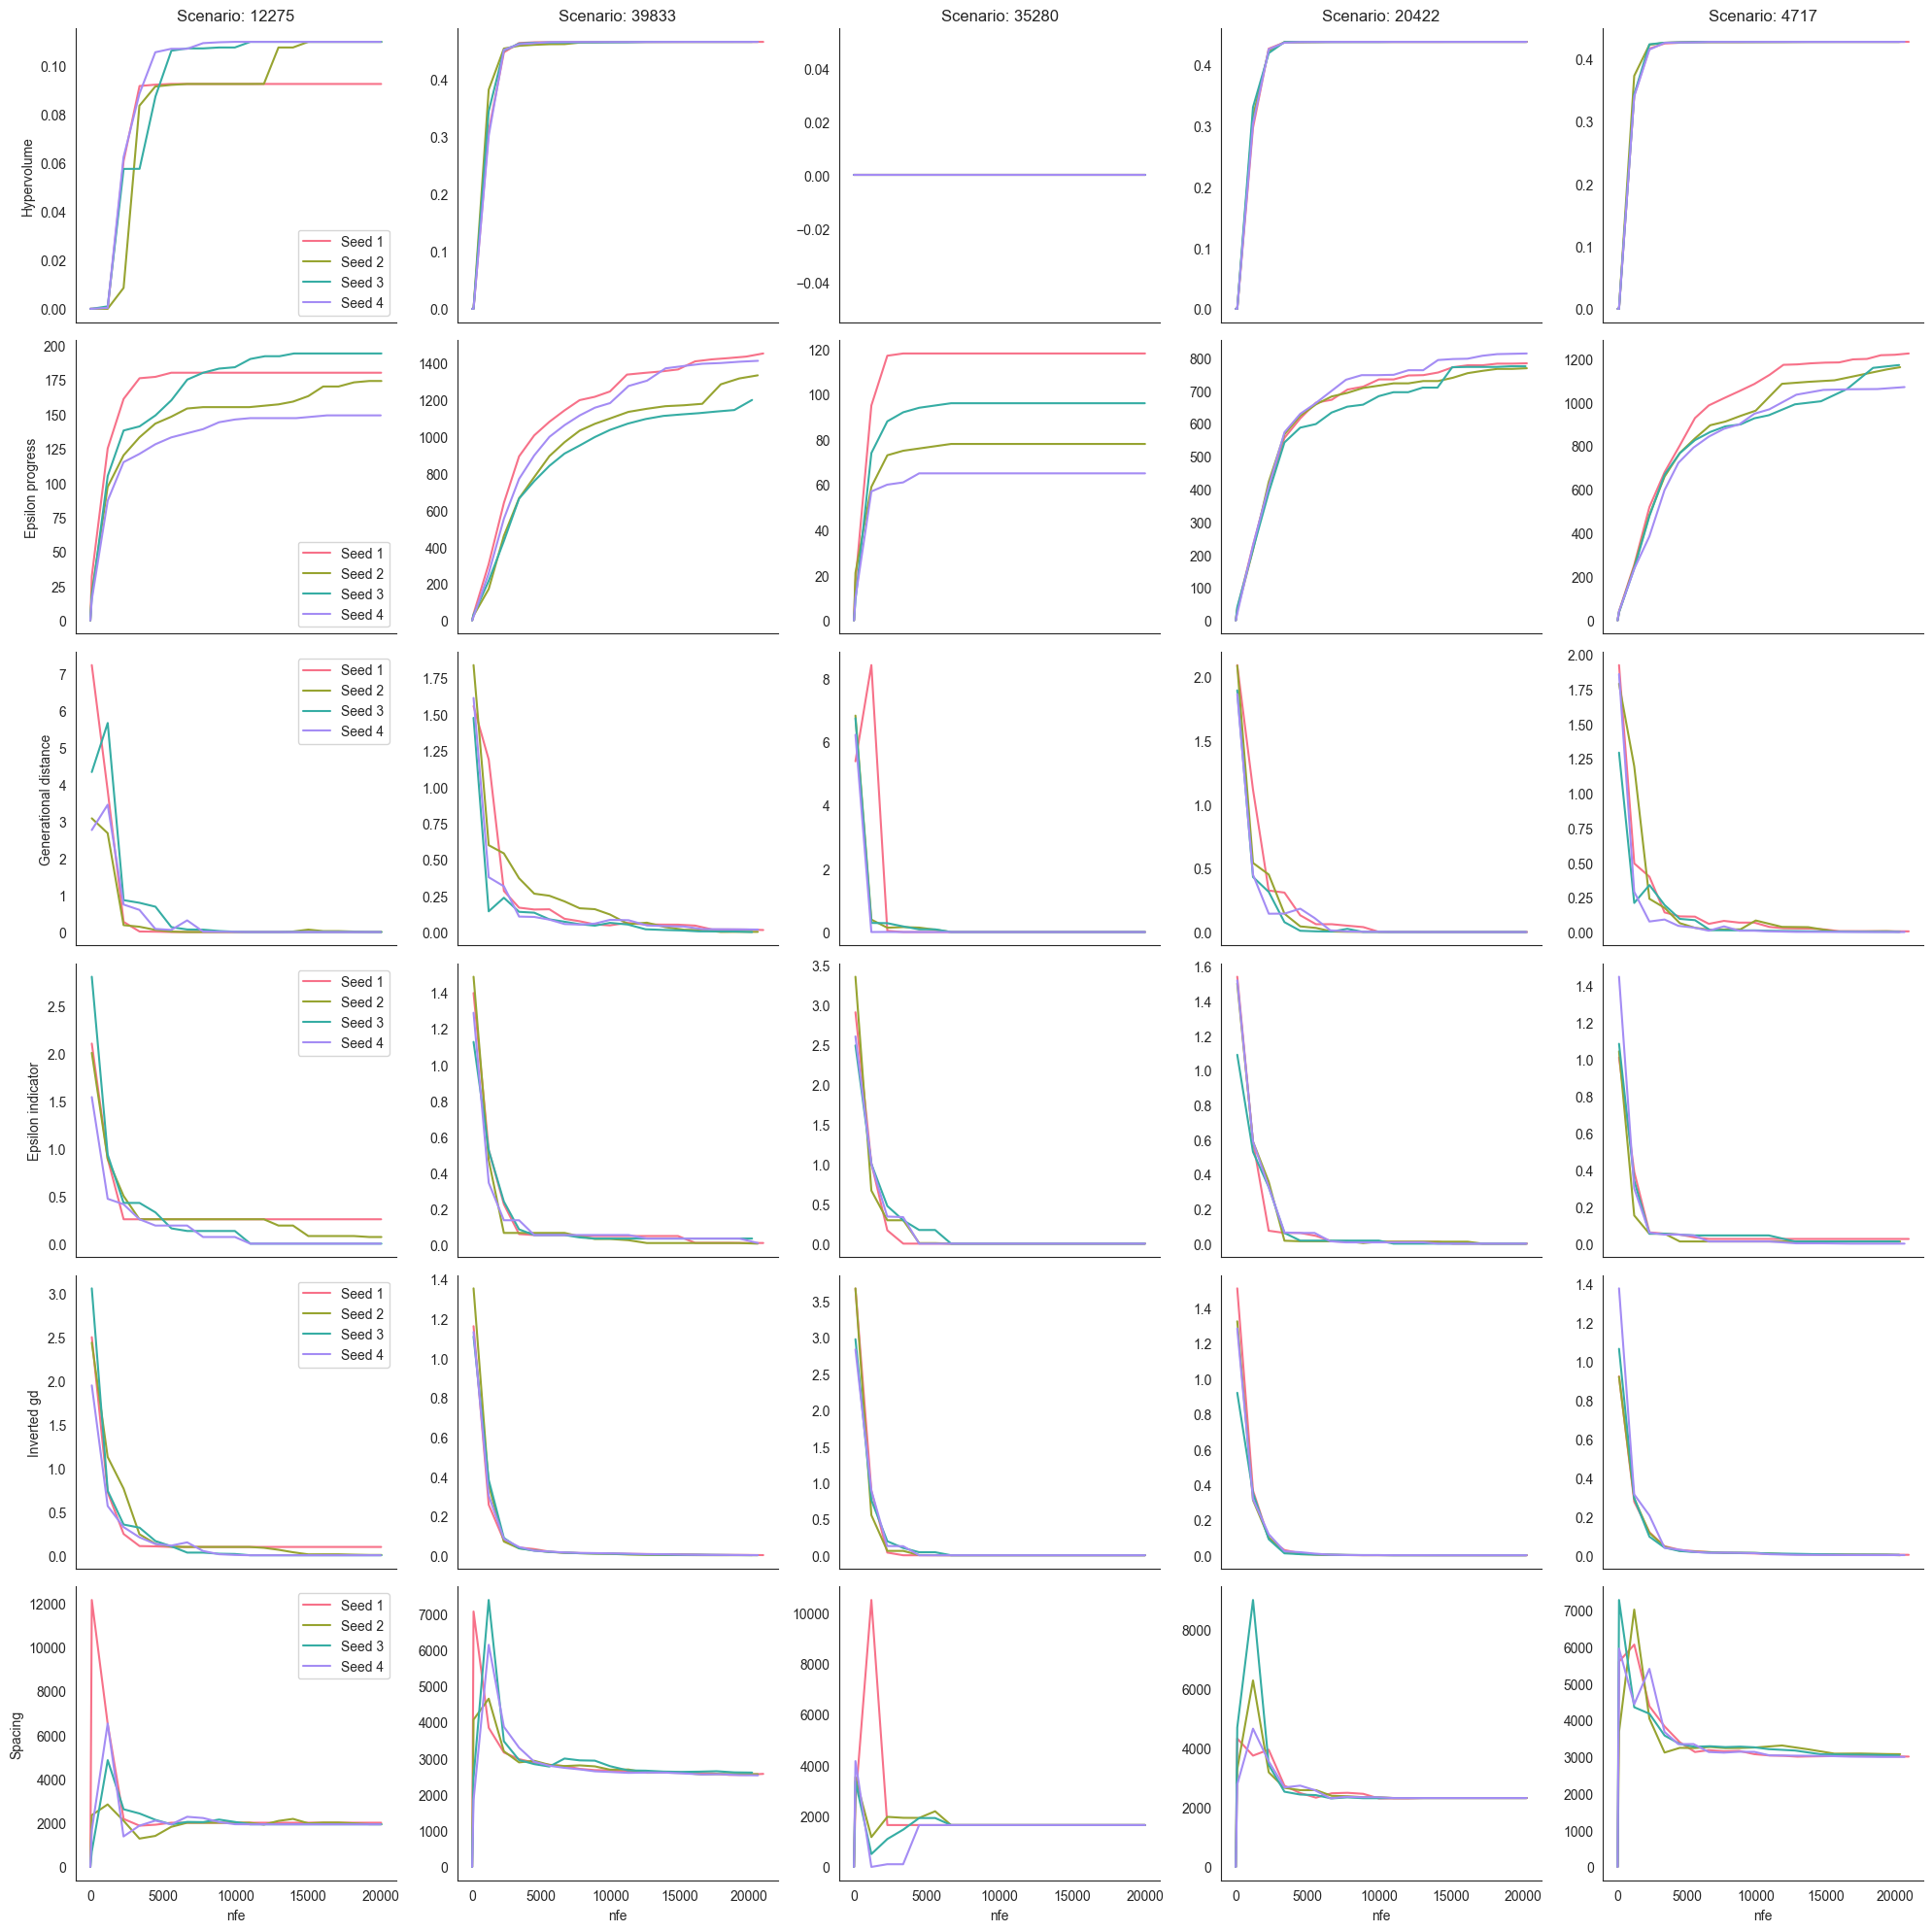

In [28]:
# Load the convergence metrics from the pickle file
with open('results/convergence_metrics.pkl', 'rb') as f:
    convergence_metrics = pickle.load(f)

# Set the style for seaborn
sns.set_style("white")

# Define the number of scenarios and metrics
num_scenarios = len(convergence_metrics)
num_metrics = 6  # hypervolume, epsilon progress, generational distance, epsilon indicator, inverted generational distance, spacing

# Create a figure with subplots
fig, axes = plt.subplots(nrows=num_metrics, ncols=num_scenarios, figsize=(20, 20), sharex='col')

# List of metric names for convergence metrics and a placeholder for epsilon progress
metric_names = ['hypervolume', 'epsilon_progress', 'generational_distance', 'epsilon_indicator', 'inverted_gd', 'spacing']

# Iterate over each scenario in the convergence metrics
for col_idx, (scenario, metrics_list) in enumerate(convergence_metrics.items()):
    # Create a color palette with enough colors for each seed in the scenario
    palette = sns.color_palette("husl", len(metrics_list))

    for row_idx, metric_name in enumerate(metric_names):
        ax = axes[row_idx, col_idx]
        if metric_name == 'epsilon_progress':
            for seed_idx, convergence in enumerate(convergence_dict[scenario]):
                color = palette[seed_idx]  # Get a color from the palette for this seed
                ax.plot(convergence['nfe'], convergence[metric_name], color=color, label=f'Seed {seed_idx+1}' if col_idx == 0 else "")
        else:
            for seed_idx, metrics in enumerate(metrics_list):
                color = palette[seed_idx]  # Get a color from the palette for this seed
                ax.plot(metrics['nfe'], metrics[metric_name], color=color, label=f'Seed {seed_idx+1}' if col_idx == 0 else "")
        
        # Set y-axis label only on the first column
        if col_idx == 0:
            ax.set_ylabel(metric_name.replace('_', ' ').capitalize())

        # Set title for each scenario in the first row
        if row_idx == 0:
            ax.set_title(f'Scenario: {scenario}')

# Set the xlabel for the last row of subplots
for ax in axes[-1, :]:
    ax.set_xlabel("nfe")

# Add legends to the first subplot in each row
for ax in axes[:, 0]:
    ax.legend()

# Despine the figure
sns.despine(fig)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig('results/convergence_metrics.png')

# Show the plot
plt.show()

In [19]:
from sklearn.preprocessing import (MinMaxScaler, StandardScaler)

def normalize_and_compute_composite_ooi(df):
    """
    Normalize the selected columns of the input dataframe using MinMaxScaler and compute the composite OOI.
    
    Parameters:
    df (pandas.DataFrame): The input dataframe containing the columns to be normalized.
    
    Returns:
    pandas.DataFrame: The input dataframe with an additional column 'composite_ooi' representing the composite OOI.
    """
    scaler = MinMaxScaler()
    normalized_ooi = scaler.fit_transform(df[['A.1_Expected Annual Damage', 'A.1_Expected Number of Deaths', 
                                              'A.2_Expected Annual Damage', 'A.2_Expected Number of Deaths']])
    composite_ooi = normalized_ooi.sum(axis=1)
    df['composite_ooi'] = composite_ooi 
    return df


In [10]:
df_12275 = normalize_and_compute_composite_ooi(policy_dict[12275])
df_39833 = normalize_and_compute_composite_ooi(policy_dict[39833])
df_35280 = normalize_and_compute_composite_ooi(policy_dict[35280])
df_20422 = normalize_and_compute_composite_ooi(policy_dict[20422])
df_4717 = normalize_and_compute_composite_ooi(policy_dict[4717])


In [11]:
df_base = pd.read_csv('results/base_case_results.csv',index_col=0)
df_base = df_base.loc[[14779, 48226, 42720, 24626, 5666]]

In [12]:
# index = scenario
# 12275 = 14779
# 39833 = 48226
# 35280 = 42720
# 20422 = 24626
# 4717 = 5666
[14779, 48226, 42720, 24626, 5666]

[14779, 48226, 42720, 24626, 5666]

In [13]:
df_base_composite_ooi = normalize_and_compute_composite_ooi(df_base)

In [14]:
df_base_14779 = (df_base_composite_ooi.iloc[[0]])
df_base_48226 = (df_base_composite_ooi.iloc[[1]])
df_base_42720 = (df_base_composite_ooi.iloc[[2]])
df_base_24626 = (df_base_composite_ooi.iloc[[3]])
df_base_5666 = (df_base_composite_ooi.iloc[[4]])

In [15]:
def compare_ooi(base_case_df, policy_df, policy_df_name):
    """
    Compare the 'composite_ooi' column between two dataframes and create a new column 'satisfied' based on the comparison.

    Parameters:
    - base_case_df (pandas.DataFrame): The base case dataframe containing the 'composite_ooi' column.
    - policy_df (pandas.DataFrame): The policy dataframe containing the 'composite_ooi' column.

    Returns:
    - result_df (pandas.DataFrame): A copy of the policy dataframe with an additional 'satisfied' column.

    Raises:
    - ValueError: If either dataframe does not contain the 'composite_ooi' column.
    - ValueError: If the two dataframes have different lengths.
    """
    # Ensure that both dataframes have the 'composite_ooi' column
    if 'composite_ooi' not in base_case_df.columns or 'composite_ooi' not in policy_df.columns:
        raise ValueError("Both dataframes must contain the 'composite_ooi' column.")
    print('Non dominated policies: ', policy_df.shape[0])
    # Ensure both dataframes have the same length
    # if len(base_case_df) != len(policy_df):
    #     raise ValueError("Both dataframes must have the same number of rows.")

    composite_ooi_base = base_case_df['composite_ooi'].values[0]
    # print(composite_ooi_base)
    
    # Create the 'satisfied' column based on the comparison
    result_df = policy_df.copy()
    result_df['scenario'] = policy_df_name
    result_df['satisfied'] = policy_df['composite_ooi'] < (composite_ooi_base * 0.1)

    # Count the number of True values in the 'satisfied' column
    true_count = result_df['satisfied'].sum()
    
    # Print the name of the policy_df and the count of True values
    print(f"DataFrame '{policy_df_name}' has {true_count} rows where 'satisfied' is True.")
    
    return result_df[result_df['satisfied'] == True]

In [16]:
df_temp_1 = compare_ooi(df_base_14779, df_12275, '14779')
df_temp_2 = compare_ooi(df_base_48226, df_39833, '48226')
df_temp_3 = compare_ooi(df_base_42720, df_35280, '42720')
df_temp_4 = compare_ooi(df_base_24626, df_20422, '24626')
df_temp_5 = compare_ooi(df_base_5666, df_4717, '5666')

df_constrained_policies = pd.concat([df_temp_1, df_temp_2, df_temp_3, df_temp_4, df_temp_5], ignore_index=True)
df_constrained_policies
# 12275 = 14779
# 39833 = 48226
# 38280 = 42720
# 20422 = 24626
# 4717 = 5666

Non dominated policies:  19
DataFrame '14779' has 1 rows where 'satisfied' is True.
Non dominated policies:  348
DataFrame '48226' has 63 rows where 'satisfied' is True.
Non dominated policies:  5
DataFrame '42720' has 1 rows where 'satisfied' is True.
Non dominated policies:  128
DataFrame '24626' has 24 rows where 'satisfied' is True.
Non dominated policies:  259
DataFrame '5666' has 70 rows where 'satisfied' is True.


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
0,1,1,0,1,0,0,0,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,0.000000,14779,True
1,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.003172,2.854952e+07,0.078999,48226,True
2,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,6.604510e+07,0.001456,1.289373e+07,0.035984,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
4,1,1,0,0,0,0,1,1,1,1,...,5,3.725520e+07,0.007034,1.001041e+08,5.335857e+07,0.006060,5.655506e+07,0.229378,48226,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,0,0,0,0,0,1,1,1,1,...,5,7.845388e+07,0.002938,4.590136e+07,7.331545e+07,0.000979,1.162395e+07,0.045049,5666,True
155,0,0,0,1,0,0,1,1,1,1,...,0,7.122315e+07,0.002983,5.199700e+07,5.941010e+07,0.005448,6.735447e+07,0.159468,5666,True
156,0,0,1,0,0,0,1,1,1,1,...,9,6.650701e+07,0.004655,8.113942e+07,6.604510e+07,0.002465,2.995538e+07,0.097020,5666,True
157,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000575,1.014320e+07,8.127741e+07,0.000212,2.477541e+06,0.009627,5666,True


In [31]:
from sklearn.cluster import KMeans

"""
    Perform directed search on a dataframe of policies.

    Parameters:
    - df_constrained_policies (pandas.DataFrame): The dataframe containing policy data.

    Returns:
    - diverse_policies (pandas.DataFrame): The diverse policies selected from the dataframe.
    """
# Assuming df is your dataframe containing policy data
# Assume policy_columns are the relevant policy attributes for clustering

df = df_constrained_policies.copy()
display(df)
policy_columns = df.columns[0:-2]  # Exclude the first column (scenario) and the last three columns (composite_ooi, satisfied, scenario)
print(policy_columns)
# Normalize the data
df_normalized = (df[policy_columns] - df[policy_columns].mean()) / df[policy_columns].std()

# Perform K-means clustering
kmeans = KMeans(n_clusters=70, random_state=0) 
clusters = kmeans.fit_predict(df[policy_columns])

# Identify representatives from each cluster
cluster_centers = kmeans.cluster_centers_
cluster_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices.append(np.where(clusters == i)[0])

# Randomly pick one or more policies from each cluster
selected_policies = []
for indices in cluster_indices:
    if len(indices) > 0:
        selected_policies.extend(np.random.choice(indices, size=min(len(indices), 1), replace=False))

# Select 50 policies
selected_policies = selected_policies[:50]

# Extract the diverse policies from the dataframe
diverse_policies = df.iloc[selected_policies]

# Save the diverse policies to a CSV file
diverse_policies.to_csv('results/50_diverse_policies.csv')


,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
0,1,1,0,1,0,0,0,1,1,1,...,5,0.000000e+00,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,0.000000,14779,True
1,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,5.941010e+07,0.003172,2.854952e+07,0.078999,48226,True
2,1,1,0,0,1,0,1,1,1,1,...,4,0.000000e+00,0.000000,0.000000e+00,6.604510e+07,0.001456,1.289373e+07,0.035984,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
4,1,1,0,0,0,0,1,1,1,1,...,5,3.725520e+07,0.007034,1.001041e+08,5.335857e+07,0.006060,5.655506e+07,0.229378,48226,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,0,0,0,0,0,0,1,1,1,1,...,5,7.845388e+07,0.002938,4.590136e+07,7.331545e+07,0.000979,1.162395e+07,0.045049,5666,True
155,0,0,0,1,0,0,1,1,1,1,...,0,7.122315e+07,0.002983,5.199700e+07,5.941010e+07,0.005448,6.735447e+07,0.159468,5666,True
156,0,0,1,0,0,0,1,1,1,1,...,9,6.650701e+07,0.004655,8.113942e+07,6.604510e+07,0.002465,2.995538e+07,0.097020,5666,True
157,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.000575,1.014320e+07,8.127741e+07,0.000212,2.477541e+06,0.009627,5666,True


Index(['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'A.1_External Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'composite_ooi'],
      dtype='object')


In [30]:
diverse_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
127,0,0,0,1,0,0,1,1,1,1,...,2,7.122315e+07,0.005965,1.039940e+08,6.604510e+07,0.001988,2.410459e+07,0.095154,5666,True
10,1,0,0,0,1,0,1,1,1,1,...,4,6.650701e+07,0.000288,5.071602e+06,7.331545e+07,0.000421,3.029834e+06,0.012987,48226,True
52,1,1,0,0,0,0,1,1,1,1,...,1,3.725520e+07,0.007034,1.001041e+08,5.941010e+07,0.001440,1.166189e+07,0.110016,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
75,0,0,1,0,0,0,1,1,1,1,...,5,6.650701e+07,0.009469,1.664247e+08,6.604510e+07,0.001210,1.176424e+07,0.134117,24626,True
103,0,1,1,0,1,0,1,1,1,1,...,2,0.000000e+00,0.000000,0.000000e+00,5.335857e+07,0.012585,1.595407e+08,0.319301,5666,True
73,0,0,1,0,0,0,1,1,1,1,...,2,3.269490e+07,0.002254,3.393898e+07,5.941010e+07,0.003119,3.319517e+07,0.101103,24626,True
100,1,0,0,0,1,0,1,1,1,1,...,3,0.000000e+00,0.000863,1.521481e+07,5.941010e+07,0.005537,6.810541e+07,0.145144,5666,True
80,0,0,1,0,0,0,1,1,1,1,...,7,3.725520e+07,0.008717,1.534423e+08,5.941010e+07,0.002106,2.062651e+07,0.147531,24626,True
92,1,0,0,0,0,0,1,1,1,1,...,2,7.122315e+07,0.004290,7.502434e+07,7.331545e+07,0.000892,1.063521e+07,0.054973,5666,True


In [19]:
from sklearn.cluster import KMeans
import numpy as np

# Define lever and outcome columns
policy_columns = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2',
       '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2',
       '4_RfR 0', '4_RfR 1', '4_RfR 2', 'EWS_DaysToThreat',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2'
]
outcome_columns = ['A.1_External Costs', 'A.1_Expected Number of Deaths',
       'A.1_Expected Annual Damage', 'A.2_External Costs',
       'A.2_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'composite_ooi'
]

# Optionally normalize outcome columns if needed

# Perform K-means clustering on lever columns
kmeans = KMeans(n_clusters=70, random_state=0)
clusters = kmeans.fit_predict(df[policy_columns])

# Identify representatives from each cluster
cluster_centers = kmeans.cluster_centers_
cluster_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices.append(np.where(clusters == i)[0])

# Select policies ensuring diversity in lever choices
selected_policies = []
for indices in cluster_indices:
    if len(indices) > 0:
        selected_policies.extend(np.random.choice(indices, size=min(len(indices), 1), replace=False))

# Select 50 policies ensuring diversity in outcomes as well
selected_policies = selected_policies[:50]  # Ensure only 50 policies are selected
diverse_policies = df.iloc[selected_policies]
diverse_policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.5_DikeIncrease 2,A.1_External Costs,A.1_Expected Number of Deaths,A.1_Expected Annual Damage,A.2_External Costs,A.2_Expected Number of Deaths,A.2_Expected Annual Damage,composite_ooi,scenario,satisfied
127,0,0,0,1,0,0,1,1,1,1,...,2,7.122315e+07,0.005965,1.039940e+08,6.604510e+07,0.001988,2.410459e+07,0.095154,5666,True
10,1,0,0,0,1,0,1,1,1,1,...,4,6.650701e+07,0.000288,5.071602e+06,7.331545e+07,0.000421,3.029834e+06,0.012987,48226,True
52,1,1,0,0,0,0,1,1,1,1,...,1,3.725520e+07,0.007034,1.001041e+08,5.941010e+07,0.001440,1.166189e+07,0.110016,48226,True
3,1,0,1,0,0,0,1,1,1,1,...,6,3.269490e+07,0.007322,1.032193e+08,6.604510e+07,0.000485,3.553914e+06,0.089572,48226,True
75,0,0,1,0,0,0,1,1,1,1,...,5,6.650701e+07,0.009469,1.664247e+08,6.604510e+07,0.001210,1.176424e+07,0.134117,24626,True
103,0,1,1,0,1,0,1,1,1,1,...,2,0.000000e+00,0.000000,0.000000e+00,5.335857e+07,0.012585,1.595407e+08,0.319301,5666,True
73,0,0,1,0,0,0,1,1,1,1,...,2,3.269490e+07,0.002254,3.393898e+07,5.941010e+07,0.003119,3.319517e+07,0.101103,24626,True
100,1,0,0,0,1,0,1,1,1,1,...,3,0.000000e+00,0.000863,1.521481e+07,5.941010e+07,0.005537,6.810541e+07,0.145144,5666,True
80,0,0,1,0,0,0,1,1,1,1,...,7,3.725520e+07,0.008717,1.534423e+08,5.941010e+07,0.002106,2.062651e+07,0.147531,24626,True
92,1,0,0,0,0,0,1,1,1,1,...,2,7.122315e+07,0.004290,7.502434e+07,7.331545e+07,0.000892,1.063521e+07,0.054973,5666,True


50 policies, nog ff uitzoeken, hoe chat m precies heeft gemaakt.